## Here we are going to Hyperparamater tune following 8 parameters using Optuna (Basyesian search)
### Number of hidden layers , neurons per layers ,number of epochs, Optimizer ,learning rate ,batch size ,Droup out rate , weight decay(lambda)


## Entire optuna process overview:
1. Create a Objective function that takes input a trial object and inside this function :

    a. Create search space/range of values to try for parameters like num of hidden layers, batch size, learning rate etc

    b. Initialize the model object

    c. Training loop

    d. Evaluation loop

# Steps to Train neural n/w with Hyper parameter tuning

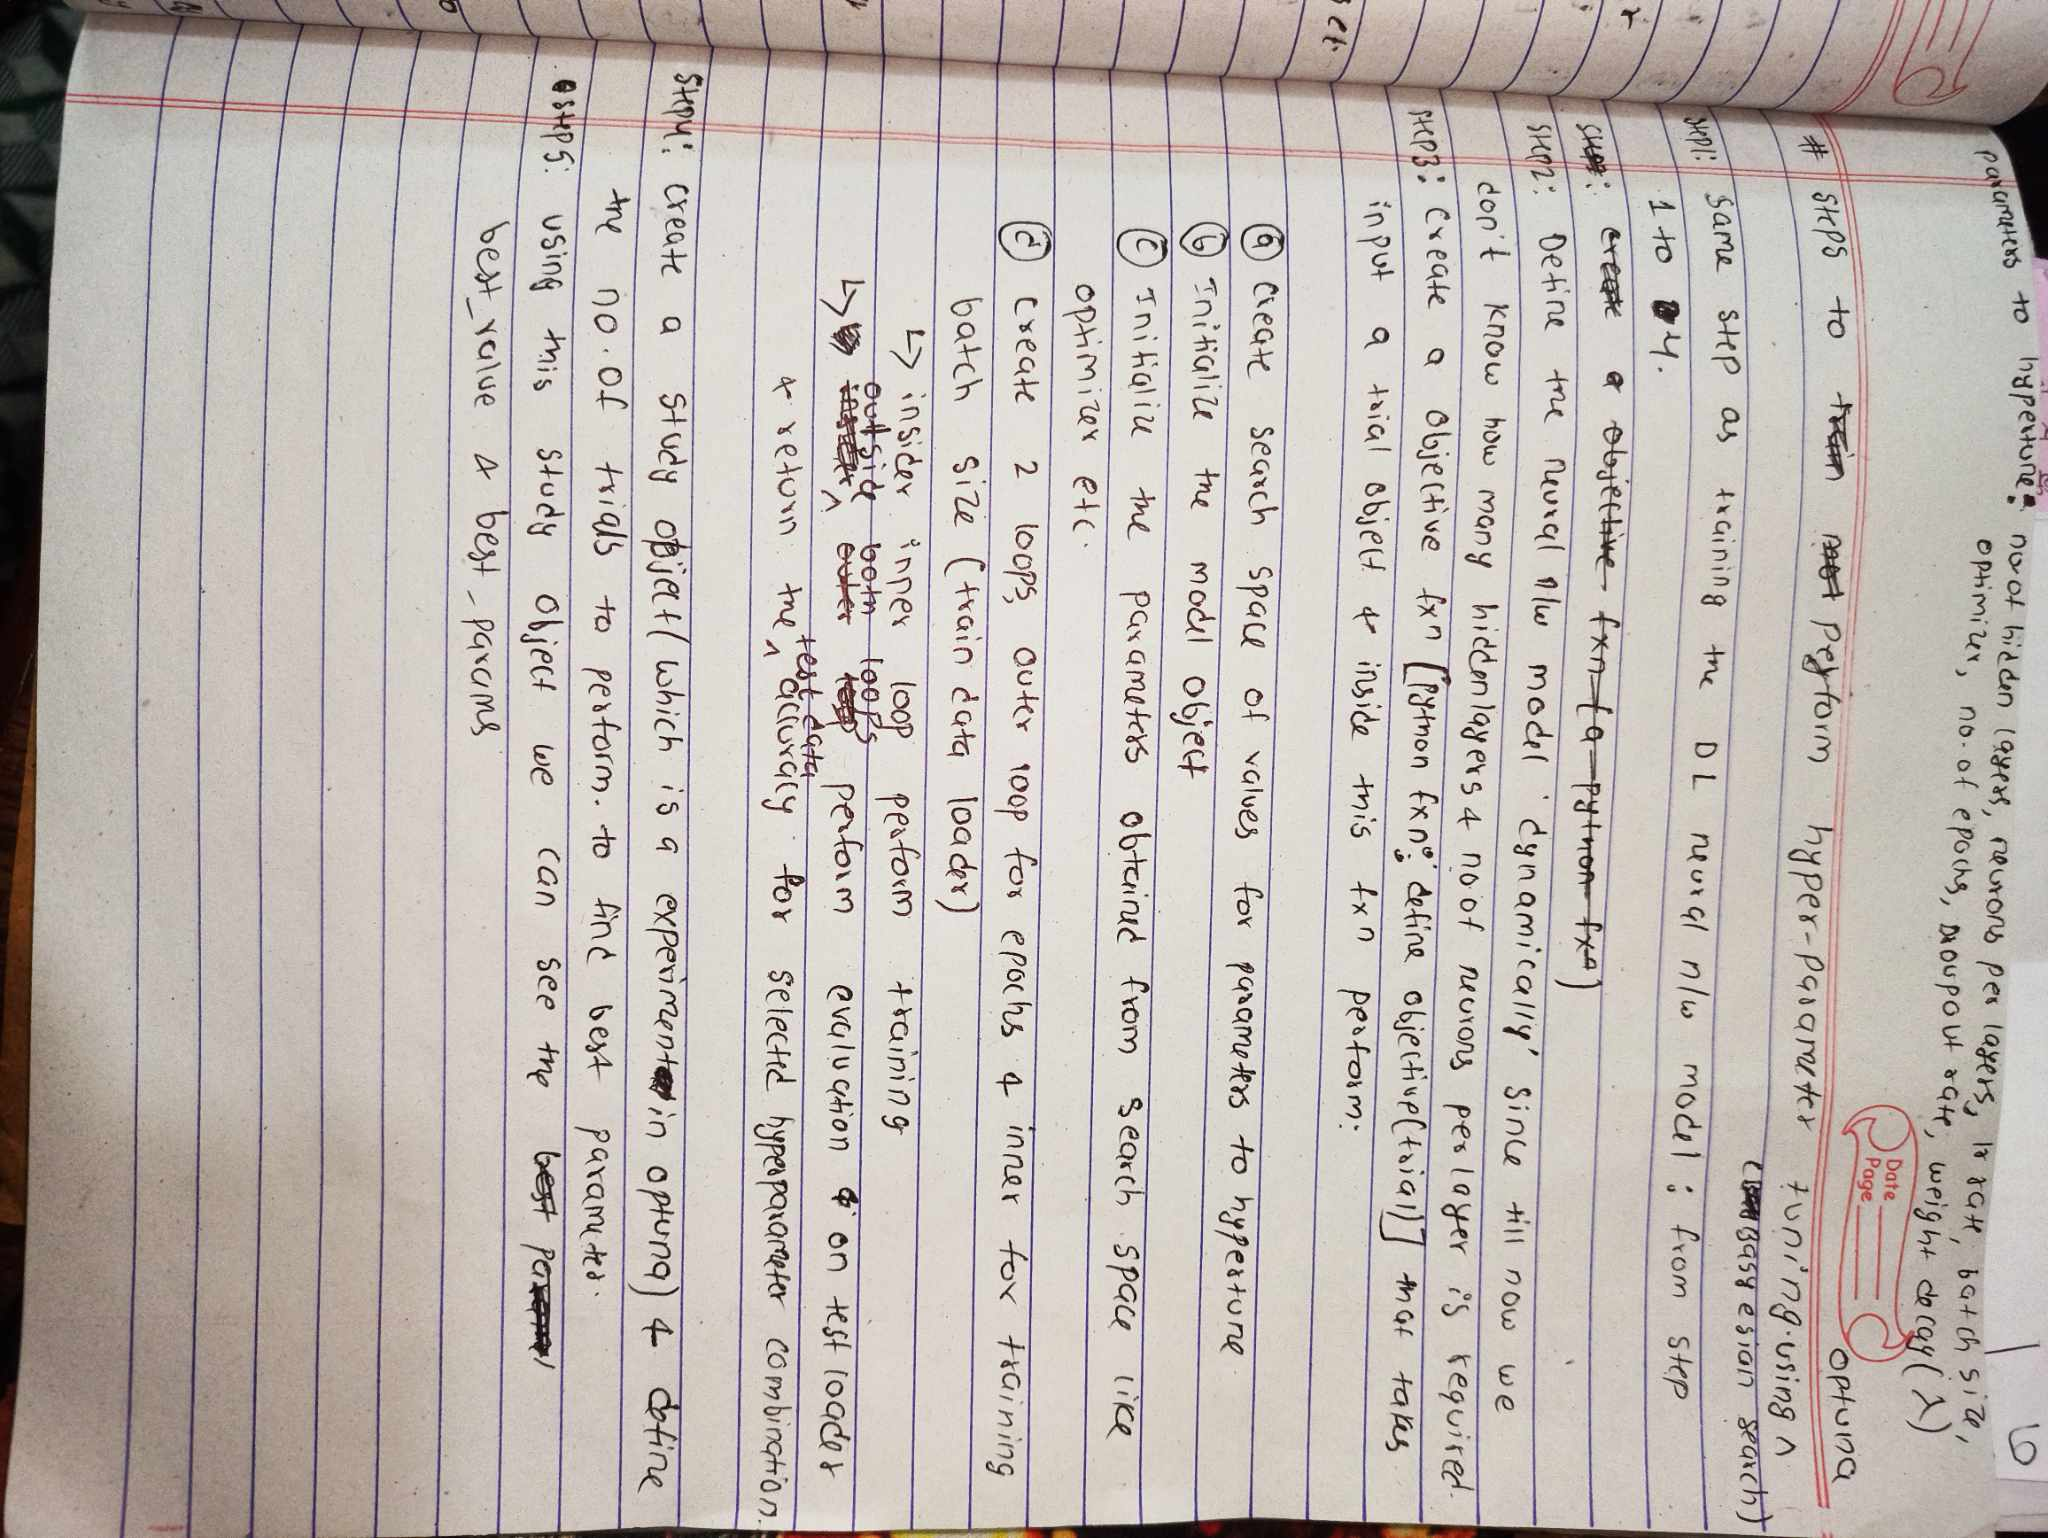

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
# Set random seeds for reproducibility
# i.e each time we run the code we get the same output
torch.manual_seed(42)

In [3]:
# Gpu step1: check GPU availability and define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
df = pd.read_csv("/content/fashion-mnist_train.csv",on_bad_lines='skip')
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
df.shape

(60000, 785)

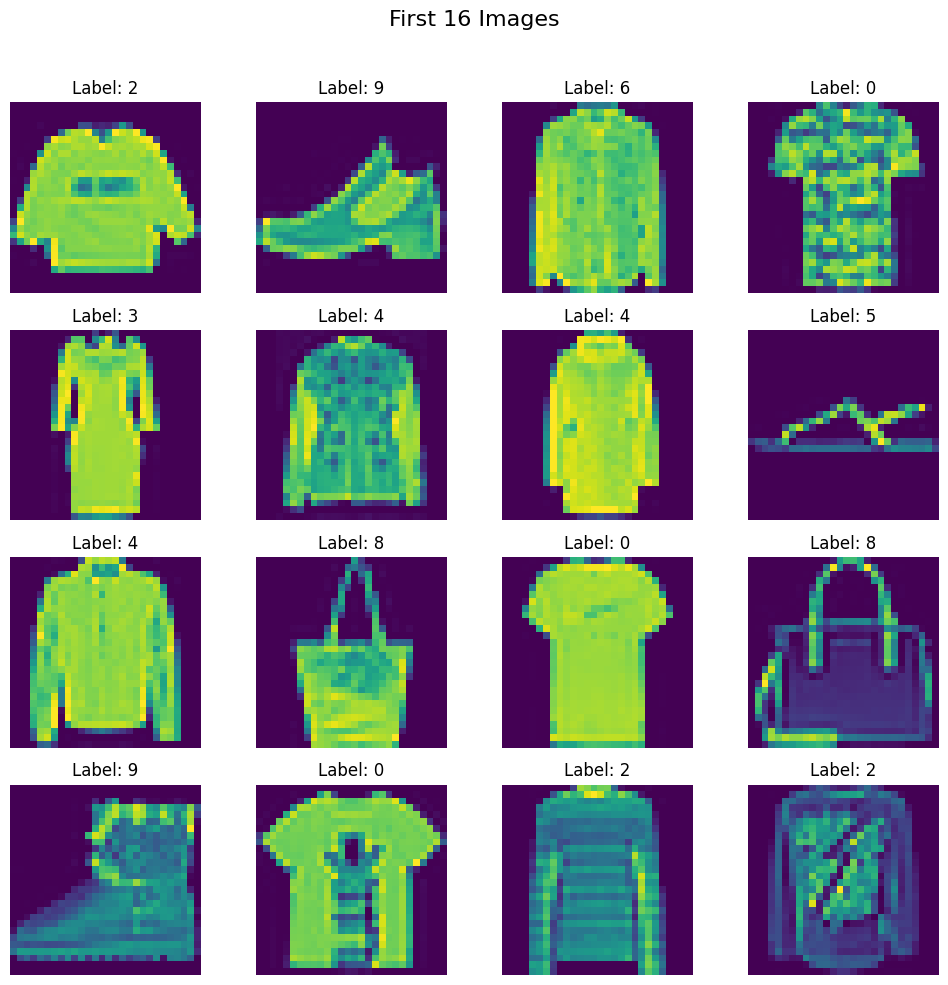

In [6]:
# This visualization code can be generated using deepseek/chatgpt ,
# Create a 4x4 grid of images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle("First 16 Images", fontsize=16)

# Plot the first 16 images from the dataset
for i, ax in enumerate(axes.flat):
    img = df.iloc[i, 1:].values.reshape(28, 28)  # Reshape to 28x28
    ax.imshow(img)  # Display in grayscale
    ax.axis('off')  # Remove axis for a cleaner look
    ax.set_title(f"Label: {df.iloc[i, 0]}")  # Show the label

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
plt.show()


In [7]:
# Train test split
x = df.iloc[:,1:].values
y = df.iloc[:,0].values

In [8]:
x.shape

(60000, 784)

In [9]:
y.shape

(60000,)

In [10]:
y

array([2, 9, 6, ..., 8, 8, 7])

In [11]:
x_train , x_test, y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [12]:
# Scaling the features , so that each pixel values is in the range of (0-1)
# Normalize and reshape data
x_train = x_train / 255.0
x_test = x_test / 255.0

In [13]:
# Converting the numpy arrays into pytorch tensors
x_train_tensor = torch.from_numpy(x_train).float()
y_train_tensor = torch.from_numpy(y_train).long()
x_test_tensor = torch.from_numpy(x_test).float()
y_test_tensor = torch.from_numpy(y_test).long()


In [14]:
len(x_train_tensor)

48000

# Create custom dataset class

In [15]:

# Creating a custom dataset class
class customdataset(Dataset):  # Inherits the Dataset class

  def __init__(self,features,labels):  # Constructor that defines how data should be loaded (Here features= x/inputs and labels=y/outputs)
    self.features = features
    self.labels = labels

  def __len__(self):    #Returns the total number of samples/rows in the dataset
    return self.features.shape[0]

  def __getitem__(self,index):   # Returns the corresponding features(x) and labels(y) based on input index to the function
    return self.features[index],self.labels[index]


In [16]:
# Creating 2 objects of dataset loader , one for training dataset and another for test dataset
train_dataset = customdataset(x_train_tensor,y_train_tensor)
test_dataset = customdataset(x_test_tensor,y_test_tensor)

In [17]:
len(train_dataset)

48000

# Step-2 Define the neural network model Dynamically since we till now dont know the 'no_of_hidden_layer' and 'neuron_per_layer'

In [18]:
class NeuralNetwork(nn.Module): # Must inherit the nn.Module class inorder to use "nn module"

  # Constructor
  def __init__(self,input_dim ,output_dim,num_hidden_layers,neurons_per_layers,dropout_rate):

    super().__init__()       #----> invoking the parent class(nn.module) constructor using super keyword

    layers = []

    # Dynamically creating the hidden layers
    for i in range(num_hidden_layers):
      layers.append(nn.Linear(input_dim,neurons_per_layers)) # hidden layers
      layers.append(nn.BatchNorm1d(neurons_per_layers))  # Batch normalization for reducing overfitting
      layers.append(nn.ReLU()) # Activation fxn
      layers.append(nn.Dropout(dropout_rate))
      input_dim = neurons_per_layers #update the num_of_inputs for next hidden layer(All hidden layers will have same number of neurons)

    # Creating a Output layer
    layers.append(nn.Linear(neurons_per_layers,output_dim)) # output layer will have 10 output neurons(output_dim=10)

    self.network = nn.Sequential(*layers) #Unpacking the list

  # Forward propogation
  def forward(self,features):
    return self.network(features)

# Step-3 Define Objective fxn for hyper paramater tuning using Optuna

In [34]:
# Objective fxn

def objective(trial):

  # 1. Search space values for hyper parameter(for.eg like learning rate ,no of epochs etc)
  num_of_hidden_layers = trial.suggest_int("num_hidden_layers",1,5) #Selection from range of 1 hidden layer to 5 hidden layer
  neurons_per_layers = trial.suggest_int("neurons_per_layers",32,128,step=8) #Consider neurons like 32 , 40 ,48 ,.... (step of 8)
  epochs = trial.suggest_int("epochs",5,10,step = 2) # Select epoch between 5 and 10 with step size 2
  learning_rate = trial.suggest_float("learning_rate",1e-5,1e-1,log=True) # range form 10^-5 to 10^-1
  dropout_rate = trial.suggest_float('dropout_rate',0.2,0.4,step=0.1)
  batch_size = trial.suggest_categorical("batch_size",[32,64,128]) # Treat batch size as categorical value between 32,64,128
  optimizer_name = trial.suggest_categorical("optimizer",['Adam','SGD','RMSprop'])
  weight_decay = trial.suggest_float("weight_decay",1e-5,1e-3,log=True) #range form 10^-5 to 10^-3



  # 2. Model object Initialize
  input_dim = 784 # number_of_input_features (since image is 28*28)
  output_dim = 10 #Number of outputs(or no_of_neurons in output layer since 10 class labels)

  model = NeuralNetwork(input_dim,output_dim,num_of_hidden_layers,neurons_per_layers,dropout_rate) # Creating object of neuralnetwork model
  model = model.to(device) #Move the neural network model to GPU


  # 3. Parameters initialize
  # 2 data loader object , one for test data and one for training data
  train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=2,pin_memory=True)  #pin_memory=True ,The training on GPU becomes faster
  test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False,num_workers=2,pin_memory=True)   #shuffle = false for test to caclulate performance metrices in better way
  loss_function = nn.CrossEntropyLoss() #Cross entropy loss for multi class classification

  if optimizer_name == 'Adam':
    optimizer = optim.Adam(model.parameters(),lr=learning_rate, weight_decay=weight_decay)  # Optimizer
  elif optimizer_name == 'SGD':
    optimizer = optim.SGD(model.parameters(),lr=learning_rate, momentum=0.9, weight_decay=weight_decay)
  else:
    optimizer = optim.RMSprop(model.parameters(),lr=learning_rate, weight_decay=weight_decay)


  # 4. Create a training pipeline/loop
  for epoch in range(epochs):

    total_epoch_loss=0 #later to calculate total loss for each epoch

    #Define inner loop for minibatch gradient descent
    for batch_features,batch_labels in train_loader:

      # Gpu step 3. Modify the training loop to move the data(features and labels) to the GPU
      batch_features,batch_labels = batch_features.to(device),batch_labels.to(device)

      #forward pass
      y_pred = model(batch_features)

      #calculate loss
      loss = loss_function(y_pred,batch_labels)

      #clear gradients
      optimizer.zero_grad()

      #backpass
      loss.backward()

      #update parameters
      optimizer.step()


  # 5. Evaluation and return accuracy
  model.eval()
  # Evaluation code on test data
  total = 0
  correct = 0

  with torch.no_grad():  #disable the gradient tracking while evaluation
    for batch_features,batch_labels in test_loader:  #since the training data are into batches

      # GPU step 4. Also Modify the evaluation loop to move the test data(features and labels to GPU)
      batch_features,batch_labels = batch_features.to(device),batch_labels.to(device)

      #forward pass
      output = model(batch_features)

      #since there are 32 images in the batch the output will be (32*10) .for each image there will be 10 probabilities output , and the image will belong to that class with highest probabilities values (for eg: output probabilities for a image :[0.2 , 0.4 ,0.1, 0.7 ,0.3] . Then this image will belong to class label :3 )
      _, predicted = torch.max(output, 1)   # Extract labels of the maximum probilities values

      total = total + batch_labels.shape[0]

      correct = correct + (predicted == batch_labels).sum().item()

  accuracy = correct/total

  print(f"accuracy : { (correct/total) * 100} %")


  return accuracy


## Creating a study object

In [28]:
!pip install optuna

In [ ]:
import optuna
study = optuna.create_study(direction='maximize')  # We aim to maximize accuracy
study.optimize(objective, n_trials=15) # Pass the objective fxn and  Run 10 trials to find the best hyperparameters

[I 2025-02-25 15:07:52,631] A new study created in memory with name: no-name-36d146f7-539b-40f3-a69b-53f8b3212837
[I 2025-02-25 15:08:33,399] Trial 0 finished with value: 0.8195 and parameters: {'num_hidden_layers': 1, 'neurons_per_layers': 80, 'epochs': 9, 'learning_rate': 4.938147023282051e-05, 'dropout_rate': 0.4, 'batch_size': 32, 'optimizer': 'SGD', 'weight_decay': 4.135650391625187e-05}. Best is trial 0 with value: 0.8195.


accuracy : 81.95 %


[I 2025-02-25 15:08:43,571] Trial 1 finished with value: 0.786 and parameters: {'num_hidden_layers': 4, 'neurons_per_layers': 56, 'epochs': 5, 'learning_rate': 0.01059166717879226, 'dropout_rate': 0.4, 'batch_size': 128, 'optimizer': 'RMSprop', 'weight_decay': 0.00026613686276812044}. Best is trial 0 with value: 0.8195.


accuracy : 78.60000000000001 %


[I 2025-02-25 15:09:28,033] Trial 2 finished with value: 0.8629166666666667 and parameters: {'num_hidden_layers': 3, 'neurons_per_layers': 88, 'epochs': 7, 'learning_rate': 0.009904376152838523, 'dropout_rate': 0.30000000000000004, 'batch_size': 32, 'optimizer': 'Adam', 'weight_decay': 1.0734731193663303e-05}. Best is trial 2 with value: 0.8629166666666667.


accuracy : 86.29166666666667 %


[I 2025-02-25 15:09:38,737] Trial 3 finished with value: 0.8465 and parameters: {'num_hidden_layers': 1, 'neurons_per_layers': 48, 'epochs': 7, 'learning_rate': 0.0034041846913677445, 'dropout_rate': 0.2, 'batch_size': 128, 'optimizer': 'RMSprop', 'weight_decay': 0.0005795450901500943}. Best is trial 2 with value: 0.8629166666666667.


accuracy : 84.65 %


[I 2025-02-25 15:09:57,708] Trial 4 finished with value: 0.8588333333333333 and parameters: {'num_hidden_layers': 1, 'neurons_per_layers': 56, 'epochs': 7, 'learning_rate': 0.002291122772131323, 'dropout_rate': 0.30000000000000004, 'batch_size': 64, 'optimizer': 'RMSprop', 'weight_decay': 0.0004290762908464348}. Best is trial 2 with value: 0.8629166666666667.


accuracy : 85.88333333333334 %


[I 2025-02-25 15:10:24,534] Trial 5 finished with value: 0.8080833333333334 and parameters: {'num_hidden_layers': 2, 'neurons_per_layers': 40, 'epochs': 9, 'learning_rate': 2.07294870003986e-05, 'dropout_rate': 0.4, 'batch_size': 64, 'optimizer': 'Adam', 'weight_decay': 0.0001299081828372169}. Best is trial 2 with value: 0.8629166666666667.


accuracy : 80.80833333333334 %


[I 2025-02-25 15:10:38,271] Trial 6 finished with value: 0.8154166666666667 and parameters: {'num_hidden_layers': 1, 'neurons_per_layers': 72, 'epochs': 5, 'learning_rate': 0.027027028566490224, 'dropout_rate': 0.30000000000000004, 'batch_size': 64, 'optimizer': 'Adam', 'weight_decay': 5.679239276102509e-05}. Best is trial 2 with value: 0.8629166666666667.


accuracy : 81.54166666666667 %


[I 2025-02-25 15:10:57,009] Trial 7 finished with value: 0.8409166666666666 and parameters: {'num_hidden_layers': 1, 'neurons_per_layers': 32, 'epochs': 7, 'learning_rate': 0.007585993894841865, 'dropout_rate': 0.30000000000000004, 'batch_size': 64, 'optimizer': 'RMSprop', 'weight_decay': 0.00016344390499221576}. Best is trial 2 with value: 0.8629166666666667.


accuracy : 84.09166666666667 %


[I 2025-02-25 15:11:18,932] Trial 8 finished with value: 0.8549166666666667 and parameters: {'num_hidden_layers': 3, 'neurons_per_layers': 64, 'epochs': 7, 'learning_rate': 0.0023693601380734438, 'dropout_rate': 0.4, 'batch_size': 64, 'optimizer': 'SGD', 'weight_decay': 0.00014511261959633355}. Best is trial 2 with value: 0.8629166666666667.


accuracy : 85.49166666666666 %


In [ ]:
study.best_value

In [ ]:
study.best_params

In [ ]:
study.best_trial